# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

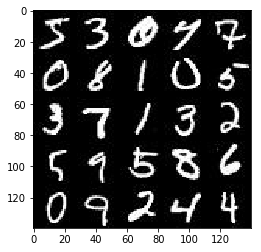

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

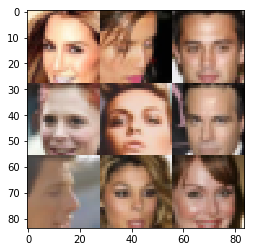

In [3]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="real_input_images")
    z_data = tf.placeholder(tf.float32,(None,z_dim),name="z_data")
    learning_rate = tf.placeholder(tf.float32,name="lr",shape=())
    return (real_input_images,z_data,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [29]:
def discriminator(images, reuse=False,alpha=0.2,dropout=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        cov1 = tf.layers.conv2d(images, 128,5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        cov1 = tf.maximum(alpha*cov1,cov1)

        cov2 = tf.layers.conv2d(cov1,256,4,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        cov2 = tf.layers.batch_normalization(cov2, training=True)
        cov2 = tf.maximum(alpha*cov2,cov2)

        cov3 = tf.layers.conv2d(cov2,512,3,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        cov3 = tf.layers.batch_normalization(cov3, training=True)
        cov3 = tf.maximum(alpha*cov3,cov3)
        
        cov4 = tf.layers.conv2d(cov3,1024,2,strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        cov4 = tf.layers.batch_normalization(cov4, training=True)
        cov4 = tf.maximum(alpha*cov4,cov4)

        flat = tf.reshape(cov4, (-1, 2*2*1024))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=dropout)
        logits = tf.layers.dense(dropout_layer, 1)
        outputs = tf.sigmoid(logits)    
    return (outputs, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        f_c = tf.layers.dense(z,7*7*256)
        f_c =tf.reshape(f_c,(-1,7,7,256))
        f_c = tf.layers.batch_normalization(f_c, training=is_train)
        f_c = tf.maximum(alpha * f_c, f_c)
        
        cov1 = tf.layers.conv2d_transpose(f_c,128,5,strides=2, padding='same')
        cov1 = tf.layers.batch_normalization(cov1, training=True)
        cov1 = tf.maximum(alpha*cov1,cov1)

        cov2 = tf.layers.conv2d_transpose(cov1,64,4,strides=2, padding='same')
        cov2 = tf.layers.batch_normalization(cov2, training=True)
        cov2 = tf.maximum(alpha*cov2,cov2)
        
        logits = tf.layers.conv2d_transpose(cov2,out_channel_dim,3,strides=1, padding='same')
        outputs = tf.tanh(logits)
        return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim,alpha=0.2, dropout=0.5):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_out = generator(input_z, out_channel_dim, is_train=True)
    d_out_real,d_logits_real = discriminator(input_real, reuse=False,alpha=alpha,dropout=dropout)
    d_out_fake,d_logits_fake = discriminator(g_out, reuse=True,alpha=alpha,dropout=dropout)
    
    dloss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=tf.ones_like(d_out_real)* 0.9))
    dloss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_out_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_out_fake)))
    d_loss = dloss_real + dloss_fake
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    d_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_optimizer, g_optimizer)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [38]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step = 0
    show_step = 100
    pstep = 20
    images_to_show = 9
    _,img_width,img_height,img_channels = data_shape
    
    real_input_images,z_data,lr = model_inputs(img_width,img_height,img_channels, z_dim)
    d_loss,g_loss = model_loss(real_input_images,z_data,img_channels,)
    d_optimizer, g_optimizer = model_opt(d_loss, g_loss, lr, beta1)
    print("Training starts")
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step = step + 1
                batch_images=batch_images*2
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                sess.run(d_optimizer, feed_dict={real_input_images: batch_images, z_data: z_batch, lr: learning_rate})
                #生成器运行两次以赶上辨识器速度
                sess.run(g_optimizer, feed_dict={z_data: z_batch, real_input_images: batch_images, lr: learning_rate})
                sess.run(g_optimizer, feed_dict={z_data: z_batch, real_input_images: batch_images, lr: learning_rate})
                
                if step % pstep == 0:
                    train_loss_d = d_loss.eval({z_data: z_batch, real_input_images: batch_images})
                    train_loss_g = g_loss.eval({z_data: z_batch})
                    print("Step: {}:".format(step),
                          "Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if step % show_step == 0:
                    show_generator_output(sess, images_to_show, z_data, img_channels, data_image_mode)
    print("Training Finished")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Training starts
Step: 20: Epoch 1/2... Discriminator Loss: 3.1425... Generator Loss: 0.0970
Step: 40: Epoch 1/2... Discriminator Loss: 2.2775... Generator Loss: 0.6112
Step: 60: Epoch 1/2... Discriminator Loss: 1.9744... Generator Loss: 0.2811
Step: 80: Epoch 1/2... Discriminator Loss: 1.4339... Generator Loss: 0.7510
Step: 100: Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.4335


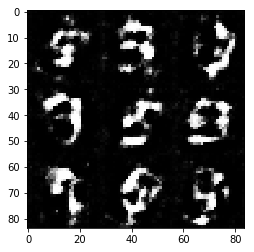

Step: 120: Epoch 1/2... Discriminator Loss: 1.4392... Generator Loss: 0.5408
Step: 140: Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5788
Step: 160: Epoch 1/2... Discriminator Loss: 1.3667... Generator Loss: 0.5445
Step: 180: Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.5632
Step: 200: Epoch 1/2... Discriminator Loss: 1.5862... Generator Loss: 0.8267


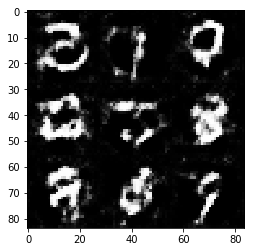

Step: 220: Epoch 1/2... Discriminator Loss: 1.7576... Generator Loss: 0.4103
Step: 240: Epoch 1/2... Discriminator Loss: 1.8183... Generator Loss: 0.3564
Step: 260: Epoch 1/2... Discriminator Loss: 1.5793... Generator Loss: 0.5236
Step: 280: Epoch 1/2... Discriminator Loss: 1.7904... Generator Loss: 0.3453
Step: 300: Epoch 1/2... Discriminator Loss: 1.6322... Generator Loss: 0.6866


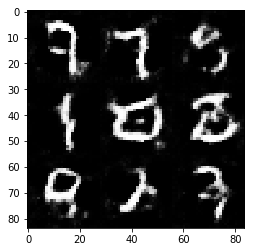

Step: 320: Epoch 1/2... Discriminator Loss: 1.5587... Generator Loss: 0.8346
Step: 340: Epoch 1/2... Discriminator Loss: 1.4946... Generator Loss: 0.6658
Step: 360: Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 0.7514
Step: 380: Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 0.7259
Step: 400: Epoch 1/2... Discriminator Loss: 1.7029... Generator Loss: 0.4455


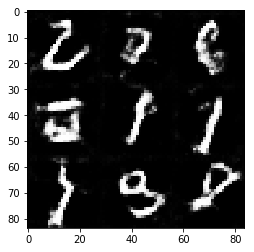

Step: 420: Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.6702
Step: 440: Epoch 1/2... Discriminator Loss: 1.3197... Generator Loss: 0.7584
Step: 460: Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 0.5935
Step: 480: Epoch 1/2... Discriminator Loss: 1.5433... Generator Loss: 0.6201
Step: 500: Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.7225


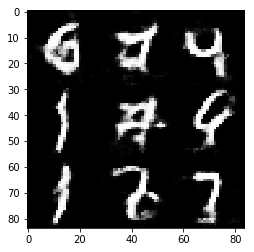

Step: 520: Epoch 1/2... Discriminator Loss: 1.5004... Generator Loss: 0.5901
Step: 540: Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.6160
Step: 560: Epoch 1/2... Discriminator Loss: 1.3508... Generator Loss: 0.8560
Step: 580: Epoch 1/2... Discriminator Loss: 1.3866... Generator Loss: 0.7021
Step: 600: Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.7997


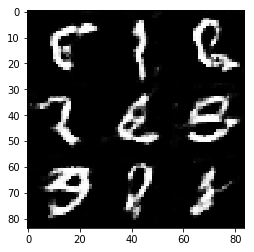

Step: 620: Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 0.8173
Step: 640: Epoch 1/2... Discriminator Loss: 1.3419... Generator Loss: 0.9069
Step: 660: Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.4853
Step: 680: Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 0.4239
Step: 700: Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.7339


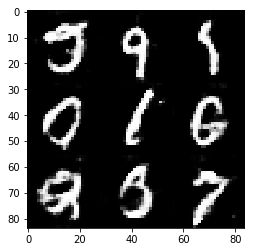

Step: 720: Epoch 1/2... Discriminator Loss: 1.5466... Generator Loss: 0.6088
Step: 740: Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.9935
Step: 760: Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.6405
Step: 780: Epoch 1/2... Discriminator Loss: 1.7570... Generator Loss: 0.3837
Step: 800: Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.6352


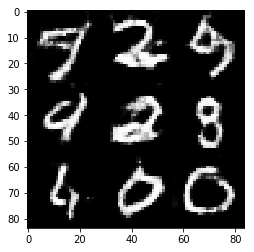

Step: 820: Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 1.5621
Step: 840: Epoch 1/2... Discriminator Loss: 1.0245... Generator Loss: 0.8452
Step: 860: Epoch 1/2... Discriminator Loss: 1.8035... Generator Loss: 0.3595
Step: 880: Epoch 1/2... Discriminator Loss: 1.2009... Generator Loss: 0.7774
Step: 900: Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 0.7291


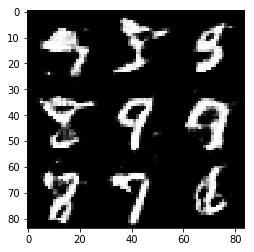

Step: 920: Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.5279
Step: 940: Epoch 2/2... Discriminator Loss: 1.6882... Generator Loss: 0.4643
Step: 960: Epoch 2/2... Discriminator Loss: 1.6665... Generator Loss: 0.3887
Step: 980: Epoch 2/2... Discriminator Loss: 1.2497... Generator Loss: 0.8197
Step: 1000: Epoch 2/2... Discriminator Loss: 1.4206... Generator Loss: 1.4299


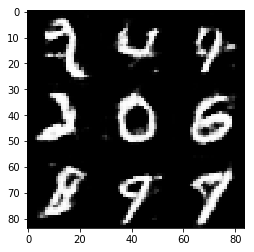

Step: 1020: Epoch 2/2... Discriminator Loss: 1.3672... Generator Loss: 0.6632
Step: 1040: Epoch 2/2... Discriminator Loss: 1.3720... Generator Loss: 0.5482
Step: 1060: Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.8984
Step: 1080: Epoch 2/2... Discriminator Loss: 1.7893... Generator Loss: 0.3314
Step: 1100: Epoch 2/2... Discriminator Loss: 1.2493... Generator Loss: 0.7404


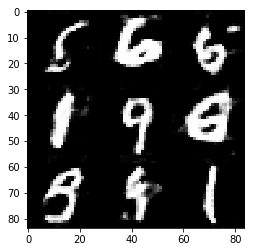

Step: 1120: Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.7231
Step: 1140: Epoch 2/2... Discriminator Loss: 1.4663... Generator Loss: 0.9944
Step: 1160: Epoch 2/2... Discriminator Loss: 1.4476... Generator Loss: 0.4870
Step: 1180: Epoch 2/2... Discriminator Loss: 1.6230... Generator Loss: 0.3739
Step: 1200: Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 0.9556


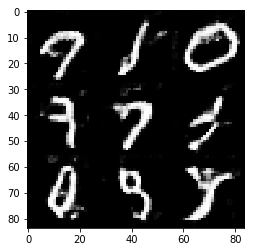

Step: 1220: Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 1.1120
Step: 1240: Epoch 2/2... Discriminator Loss: 1.2279... Generator Loss: 0.7990
Step: 1260: Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.8648
Step: 1280: Epoch 2/2... Discriminator Loss: 1.9644... Generator Loss: 0.2855
Step: 1300: Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 0.9763


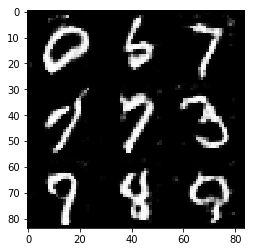

Step: 1320: Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 1.0014
Step: 1340: Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.8991
Step: 1360: Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.8242
Step: 1380: Epoch 2/2... Discriminator Loss: 1.6899... Generator Loss: 0.3465
Step: 1400: Epoch 2/2... Discriminator Loss: 1.4638... Generator Loss: 1.7976


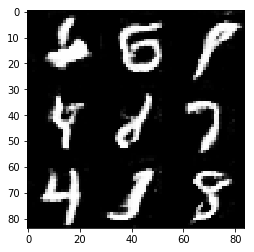

Step: 1420: Epoch 2/2... Discriminator Loss: 1.3020... Generator Loss: 0.6559
Step: 1440: Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.5767
Step: 1460: Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.8282
Step: 1480: Epoch 2/2... Discriminator Loss: 1.5263... Generator Loss: 0.4738
Step: 1500: Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 1.3749


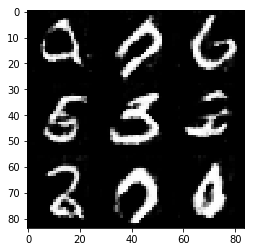

Step: 1520: Epoch 2/2... Discriminator Loss: 1.3027... Generator Loss: 0.6163
Step: 1540: Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 1.0316
Step: 1560: Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 1.2229
Step: 1580: Epoch 2/2... Discriminator Loss: 1.1950... Generator Loss: 0.7209
Step: 1600: Epoch 2/2... Discriminator Loss: 1.3390... Generator Loss: 0.5947


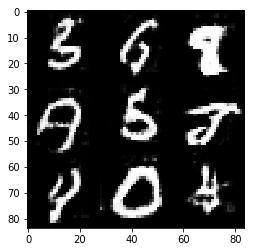

Step: 1620: Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 0.8151
Step: 1640: Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 1.1479
Step: 1660: Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.5319
Step: 1680: Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.3164
Step: 1700: Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.6598


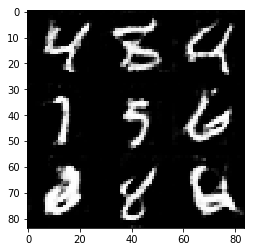

Step: 1720: Epoch 2/2... Discriminator Loss: 1.5003... Generator Loss: 0.4565
Step: 1740: Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.9608
Step: 1760: Epoch 2/2... Discriminator Loss: 1.0755... Generator Loss: 1.0627
Step: 1780: Epoch 2/2... Discriminator Loss: 1.7893... Generator Loss: 0.3466
Step: 1800: Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.8629


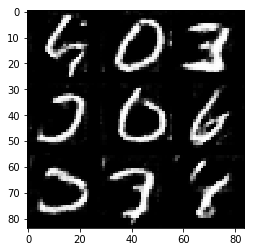

Step: 1820: Epoch 2/2... Discriminator Loss: 1.4528... Generator Loss: 0.5257
Step: 1840: Epoch 2/2... Discriminator Loss: 1.4923... Generator Loss: 0.5398
Step: 1860: Epoch 2/2... Discriminator Loss: 1.1289... Generator Loss: 1.0644
Training Finished


In [28]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Training starts
Step: 20: Epoch 1/1... Discriminator Loss: 2.4337... Generator Loss: 0.1390
Step: 40: Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.3570
Step: 60: Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.6086
Step: 80: Epoch 1/1... Discriminator Loss: 1.6467... Generator Loss: 0.4521
Step: 100: Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.6828


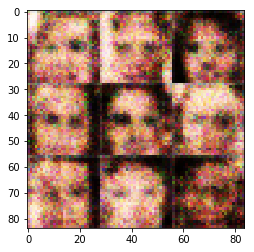

Step: 120: Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.7001
Step: 140: Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.7523
Step: 160: Epoch 1/1... Discriminator Loss: 2.1181... Generator Loss: 0.2118
Step: 180: Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7830
Step: 200: Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.6515


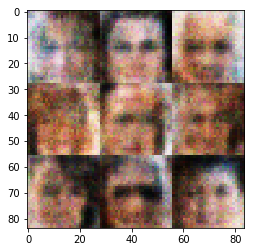

Step: 220: Epoch 1/1... Discriminator Loss: 1.1602... Generator Loss: 0.8192
Step: 240: Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.3206
Step: 260: Epoch 1/1... Discriminator Loss: 1.6753... Generator Loss: 0.4446
Step: 280: Epoch 1/1... Discriminator Loss: 1.6014... Generator Loss: 0.3744
Step: 300: Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 1.5065


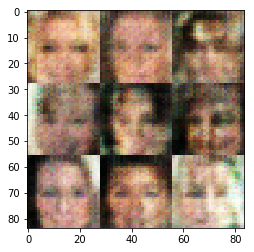

Step: 320: Epoch 1/1... Discriminator Loss: 1.5463... Generator Loss: 1.0975
Step: 340: Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7861
Step: 360: Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.5521
Step: 380: Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.4696
Step: 400: Epoch 1/1... Discriminator Loss: 1.1647... Generator Loss: 0.7018


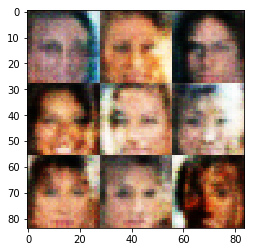

Step: 420: Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.5501
Step: 440: Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8994
Step: 460: Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.3260
Step: 480: Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.6563
Step: 500: Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.8832


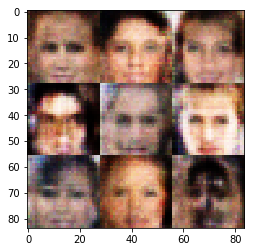

Step: 520: Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.7555
Step: 540: Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6151
Step: 560: Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4683
Step: 580: Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7759
Step: 600: Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.4521


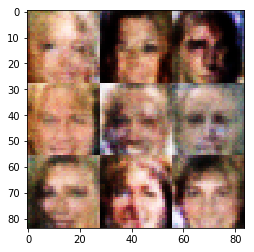

Step: 620: Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 1.2126
Step: 640: Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5737
Step: 660: Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.5477
Step: 680: Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.9917
Step: 700: Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.8320


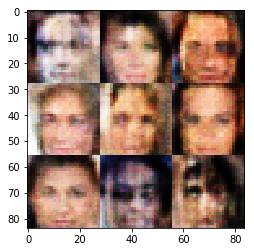

Step: 720: Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.6540
Step: 740: Epoch 1/1... Discriminator Loss: 1.1431... Generator Loss: 0.7332
Step: 760: Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.9370
Step: 780: Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4399
Step: 800: Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.8424


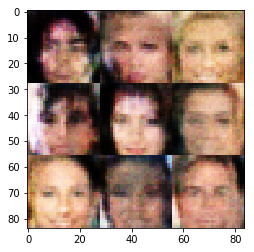

Step: 820: Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.7769
Step: 840: Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.4249
Step: 860: Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6808
Step: 880: Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 0.3311
Step: 900: Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.7113


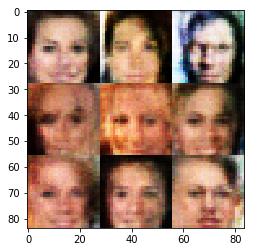

Step: 920: Epoch 1/1... Discriminator Loss: 1.5908... Generator Loss: 0.4867
Step: 940: Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.5189
Step: 960: Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.4876
Step: 980: Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7603
Step: 1000: Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.3768


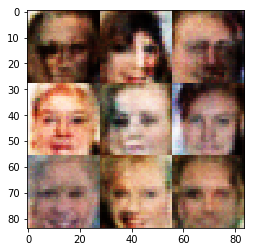

Step: 1020: Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.6841
Step: 1040: Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 1.0024
Step: 1060: Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.0157
Step: 1080: Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.6813
Step: 1100: Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.3464


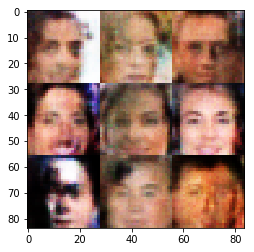

Step: 1120: Epoch 1/1... Discriminator Loss: 1.8008... Generator Loss: 0.3140
Step: 1140: Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.5906
Step: 1160: Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5238
Step: 1180: Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 0.3125
Step: 1200: Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.4332


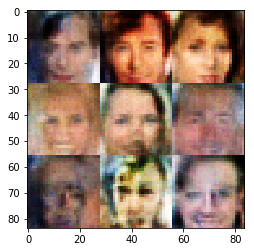

Step: 1220: Epoch 1/1... Discriminator Loss: 1.6109... Generator Loss: 0.3608
Step: 1240: Epoch 1/1... Discriminator Loss: 1.2742... Generator Loss: 0.6337
Step: 1260: Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.4822
Step: 1280: Epoch 1/1... Discriminator Loss: 1.7938... Generator Loss: 0.2824
Step: 1300: Epoch 1/1... Discriminator Loss: 1.4930... Generator Loss: 0.4207


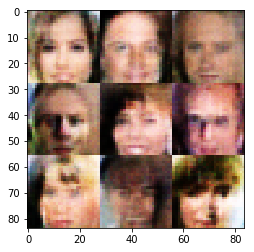

Step: 1320: Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5969
Step: 1340: Epoch 1/1... Discriminator Loss: 1.8796... Generator Loss: 0.3096
Step: 1360: Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.4119
Step: 1380: Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6616
Step: 1400: Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6235


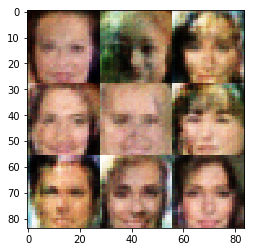

Step: 1420: Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.4321
Step: 1440: Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7275
Step: 1460: Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.4698
Step: 1480: Epoch 1/1... Discriminator Loss: 1.5415... Generator Loss: 0.3927
Step: 1500: Epoch 1/1... Discriminator Loss: 1.8068... Generator Loss: 0.2774


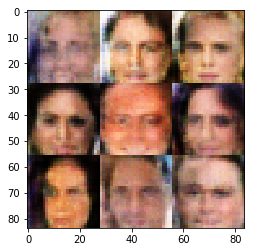

Step: 1520: Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6032
Step: 1540: Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7761
Step: 1560: Epoch 1/1... Discriminator Loss: 1.6705... Generator Loss: 0.3427
Step: 1580: Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.4246
Step: 1600: Epoch 1/1... Discriminator Loss: 1.8207... Generator Loss: 0.2917


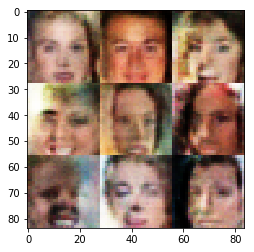

Step: 1620: Epoch 1/1... Discriminator Loss: 1.9230... Generator Loss: 0.2505
Step: 1640: Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.3780
Step: 1660: Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.5518
Step: 1680: Epoch 1/1... Discriminator Loss: 1.7590... Generator Loss: 0.2919
Step: 1700: Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.4007


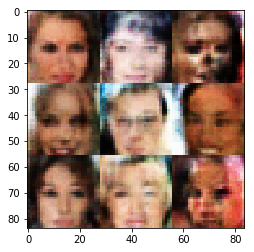

Step: 1720: Epoch 1/1... Discriminator Loss: 1.5020... Generator Loss: 0.5168
Step: 1740: Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4269
Step: 1760: Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.4753
Step: 1780: Epoch 1/1... Discriminator Loss: 1.7063... Generator Loss: 0.6527
Step: 1800: Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.9916


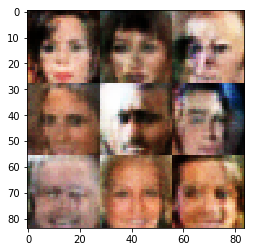

Step: 1820: Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.4195
Step: 1840: Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.4674
Step: 1860: Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 0.8950
Step: 1880: Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.5866
Step: 1900: Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.4788


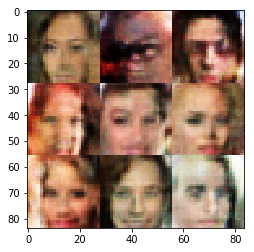

Step: 1920: Epoch 1/1... Discriminator Loss: 1.7010... Generator Loss: 0.3276
Step: 1940: Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.4159
Step: 1960: Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.4932
Step: 1980: Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.7016
Step: 2000: Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.7537


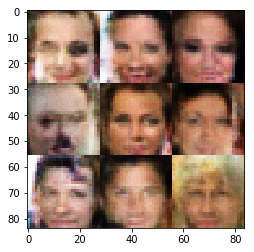

Step: 2020: Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.4072
Step: 2040: Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5326
Step: 2060: Epoch 1/1... Discriminator Loss: 1.6964... Generator Loss: 0.3178
Step: 2080: Epoch 1/1... Discriminator Loss: 1.6040... Generator Loss: 0.3873
Step: 2100: Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.4150


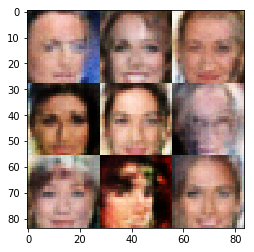

Step: 2120: Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6475
Step: 2140: Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.5236
Step: 2160: Epoch 1/1... Discriminator Loss: 1.7789... Generator Loss: 0.3110
Step: 2180: Epoch 1/1... Discriminator Loss: 1.4945... Generator Loss: 0.4363
Step: 2200: Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.4939


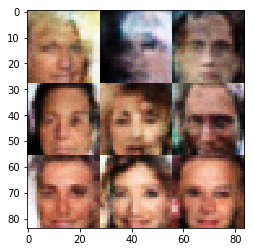

Step: 2220: Epoch 1/1... Discriminator Loss: 1.6601... Generator Loss: 0.3487
Step: 2240: Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.4882
Step: 2260: Epoch 1/1... Discriminator Loss: 1.7727... Generator Loss: 0.3211
Step: 2280: Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.3390
Step: 2300: Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.4727


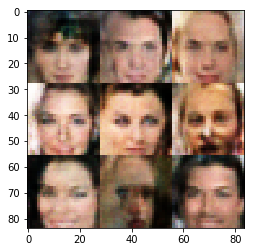

Step: 2320: Epoch 1/1... Discriminator Loss: 1.5147... Generator Loss: 0.4450
Step: 2340: Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6075
Step: 2360: Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.3622
Step: 2380: Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8814
Step: 2400: Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.3607


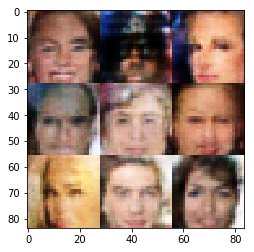

Step: 2420: Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.3426
Step: 2440: Epoch 1/1... Discriminator Loss: 1.9078... Generator Loss: 0.2530
Step: 2460: Epoch 1/1... Discriminator Loss: 1.7895... Generator Loss: 0.2919
Step: 2480: Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.5084
Step: 2500: Epoch 1/1... Discriminator Loss: 1.6076... Generator Loss: 0.3614


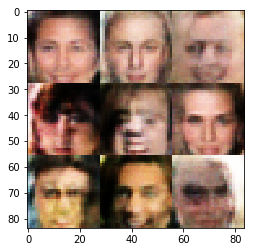

Step: 2520: Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.5042
Step: 2540: Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 0.6189
Step: 2560: Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9626
Step: 2580: Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.9009
Step: 2600: Epoch 1/1... Discriminator Loss: 1.7293... Generator Loss: 0.3091


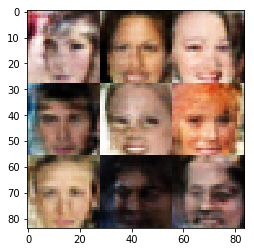

Step: 2620: Epoch 1/1... Discriminator Loss: 1.9795... Generator Loss: 0.2309
Training Finished


In [39]:
batch_size = 32
z_dim = 84
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.